# Part II - Reasons for departure delay and its change over time
## by Julia Kinday

## Investigation Overview

In this data set I looked into departure delays, their destribution, time trends and correlations with reported reasonf for delay. 


## Dataset Overview

The dataset is 22000 sample of US domestic flights data taken from 22 separate file, each representing one year between 1987 and 2008. The features included: carriers, arrival and departure delays, reasons for delays. The delay reason presented beginning from 2003.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
# Force plots to be rendered in HiDPI resolution
# Remove if causes issues on non-HiDPI screen
%config InlineBackend.figure_format = 'retina'

In [4]:
# Load the dataset
flights = pd.read_csv('combined.csv', index_col=0)
flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1987,11,28,6,2042.0,2025,2105.0,2053,PI,801,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1987,10,22,4,1805.0,1800,1933.0,1905,HP,226,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1987,11,19,4,657.0,655,821.0,804,PI,79,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1987,11,23,1,1848.0,1835,1944.0,1920,DL,653,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1987,11,25,3,703.0,655,828.0,821,AA,2277,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


#### Define functions, create sub-datasets and make additional wrangling

In [5]:
# Drop 12 columns
to_drop = ['DepTime', 'ArrTime', 'CRSArrTime','CRSDepTime', 'FlightNum', 'TailNum','CRSElapsedTime', 'ActualElapsedTime', 'AirTime',
           'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted']

flights = flights.drop(to_drop, axis=1)

# set basic color
color = '#619b8a'

In [6]:
# Remove extreme outliers 
Q1 = flights.DepDelay.quantile(0.25)
Q3 = flights.DepDelay.quantile(0.75)
IQR = Q3 - Q1
extr_margin = IQR * 3 + Q3

flights = flights[flights['DepDelay'] < extr_margin]

In [7]:
# Get airlines names from their codes in UniqueCarrier column
df= pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat',
                skiprows=1, names=['AirlineID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'],
                usecols=['Name', 'IATA', 'Country'])

def map_carrier_codes(codes):
    return list(map(lambda x: df.loc[df.IATA==x].Name.to_string(index=False), codes))

In [8]:
# Prepare to plot 5 timelines for top 5 carriers with the most of departure delays
airline_names = {'DL': 'Delta Air Lines', 'US': 'US Airways', 'WN': 'Southwest Airlines', 'UA': 'United Airlines',
                 'AA': 'American Airlines'}

top5_airlines = [{'airline':'DL', 'color':'#233d4d'},
                 {'airline':'US', 'color':'#fe7f2d'},
                 {'airline':'WN', 'color':'#fcca46'},
                 {'airline':'UA', 'color':'#a1c181'},
                 {'airline':'AA', 'color':'#619b8a'}]

def plot_delay(params):
    means = flights[flights['UniqueCarrier'] == params['airline']].groupby(['Year']).mean().reset_index() 
    artist, = plt.plot(means['Year'], means['DepDelay'], linestyle='solid', color=params['color'])
    return artist

In [13]:
# Find and drop arrival delay outliers
Q1arr = flights.ArrDelay.quantile(0.25)
Q3arr = flights.ArrDelay.quantile(0.75)
IQRarr = Q3 - Q1
margin_arr = IQRarr * 3 + Q3arr
count_arr = flights[flights['ArrDelay'] > margin_arr].Year.count()

flights_mod = flights[flights['ArrDelay'] < margin_arr]

In [10]:
# Prepare dataset to plot reasons of delay as categories

month_delays = flights.groupby('Month').mean().reset_index()
tdrop = ['Year', 'DayofMonth', 'DayOfWeek', 'ArrDelay', 'SecurityDelay']
month_delays = month_delays.drop(tdrop, axis=1)
month_delays['Month'] = month_delays['Month'].astype(str).str.zfill(2)

month_tidy = month_delays.melt(id_vars='Month').sort_values('Month')

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
del_colors = ['#fe7f2d', '#0077b6', '#a1c181', '#fcca46', '#619b8a']

## Departure Delay Distribution
The feature distribution is hightly right skewed with many outliers, values varie from negative values in original data to 1433 minuts in presented sample, but most delays are within 1-60 minutes.

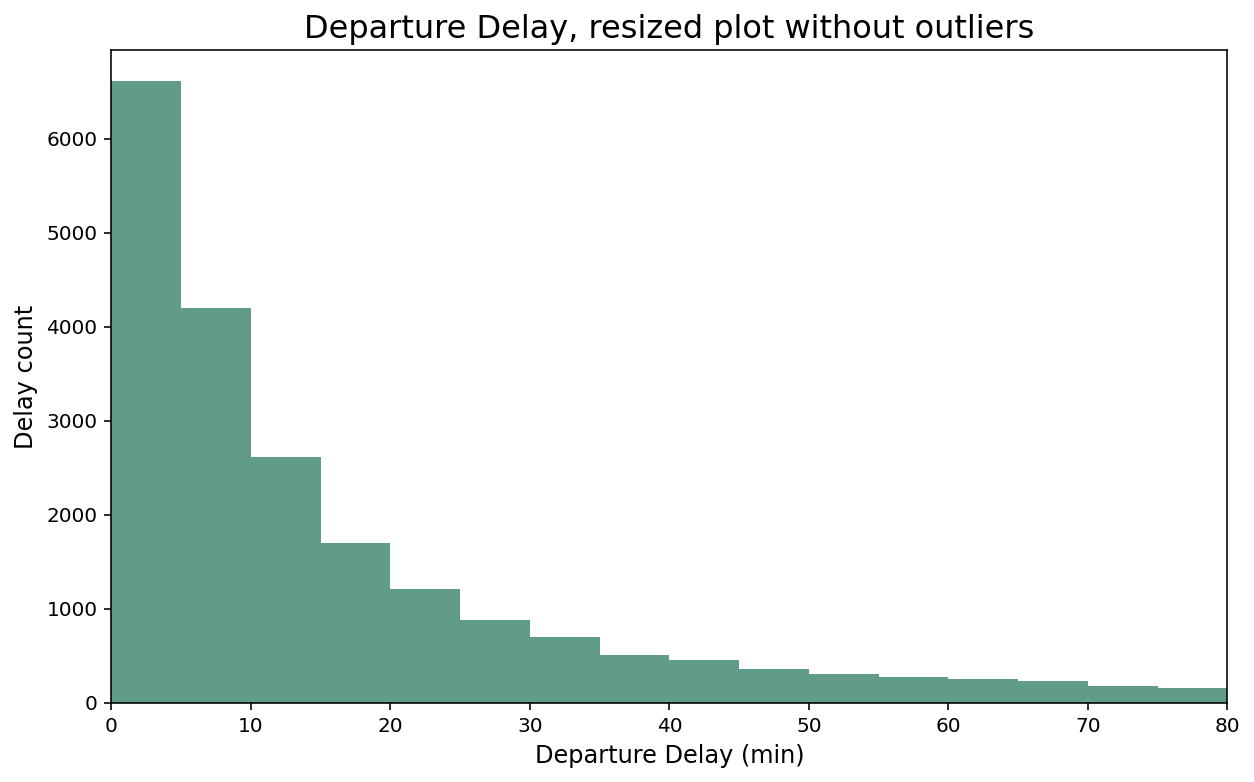

In [33]:
# Plot DepDelay, resized
binsize = 5
bins = np.arange(0, flights['DepDelay'].max()+binsize, binsize)

plt.figure(figsize = [10, 6])
plt.hist(data = flights, x = 'DepDelay', bins=bins, color=color)
plt.xlabel('Departure Delay (min)', fontsize=12)
plt.ylabel('Delay count', fontsize=12)
plt.xlim((0,80))
plt.title('Departure Delay, resized plot without outliers', fontsize=16);

## Delay time trend over 22 years
A time plot shows increase in mean departure delay and its standart deviation over the years despite the same amount of data sampled for each year. This may probably mean that flights frequency increases as industry develops and airports become more busy.

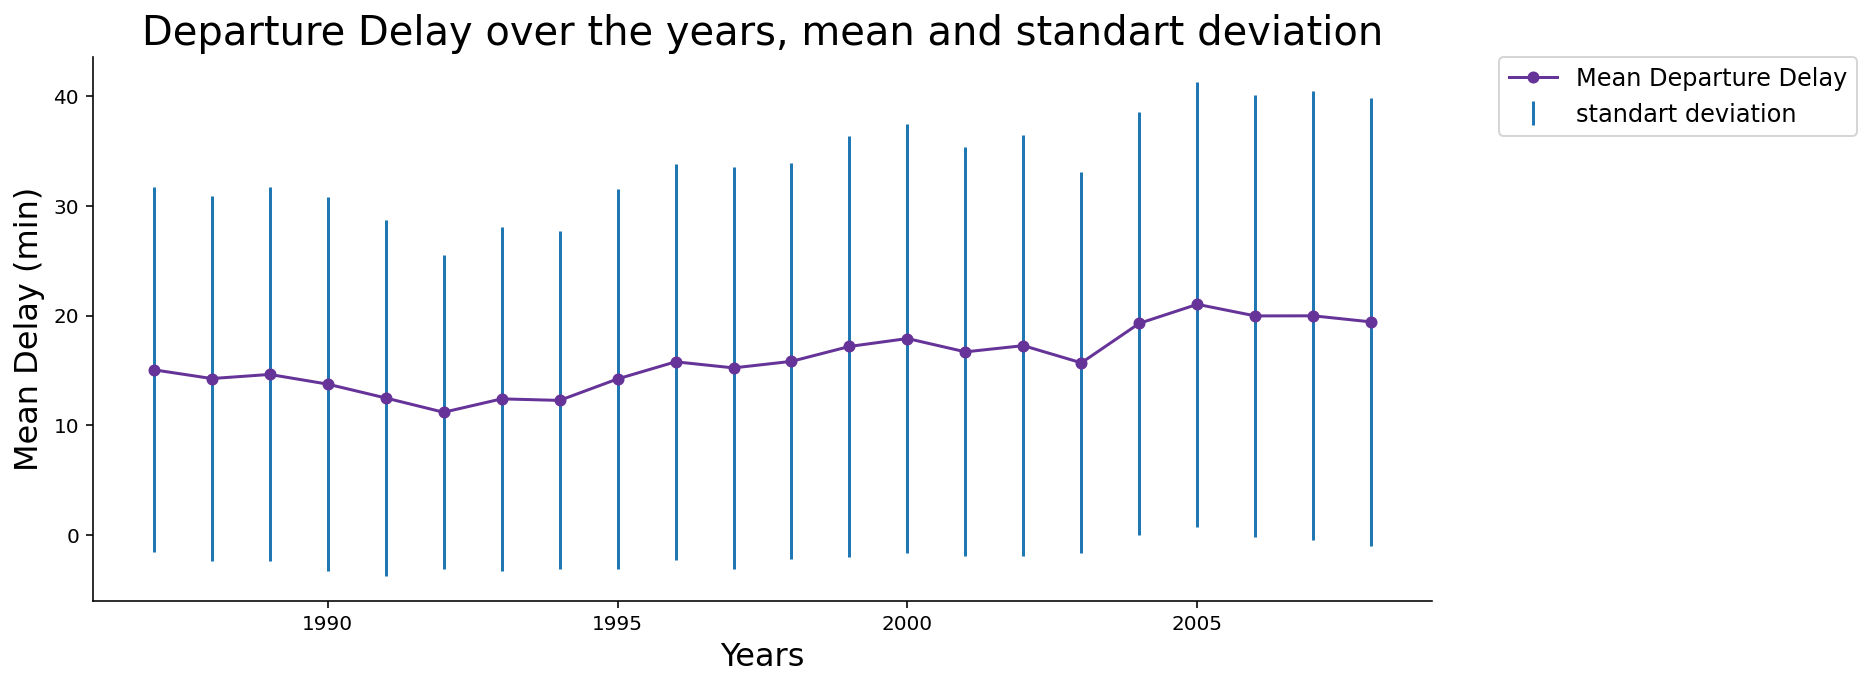

In [36]:
# Calculate mean departure delay for every year and plot it with standart diviation
delay_means = flights.groupby(['Year']).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 5))
plot_artist, = plt.plot(delay_means['Year'], delay_means['DepDelay'], linestyle='solid', markersize=10, marker='.', color='rebeccapurple')
sb.despine(top=True)

std = flights.groupby(['Year']).std().DepDelay
errorbar_artist = plt.errorbar(delay_means['Year'], delay_means['DepDelay'], yerr=std, linestyle='None')
ax.set_ylabel('Mean Delay (min)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
ax.set_title("Departure Delay over the years, mean and standart deviation" , fontsize=20)
ax.legend([plot_artist, errorbar_artist], ['Mean Departure Delay', 'standart deviation'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12);

## Top 5 airlines
Looking into carriers and their proportions shows that 5 out of 29 carriers are responsible for more than 60% of delays but at the same time their mean departure delay are relatively low.

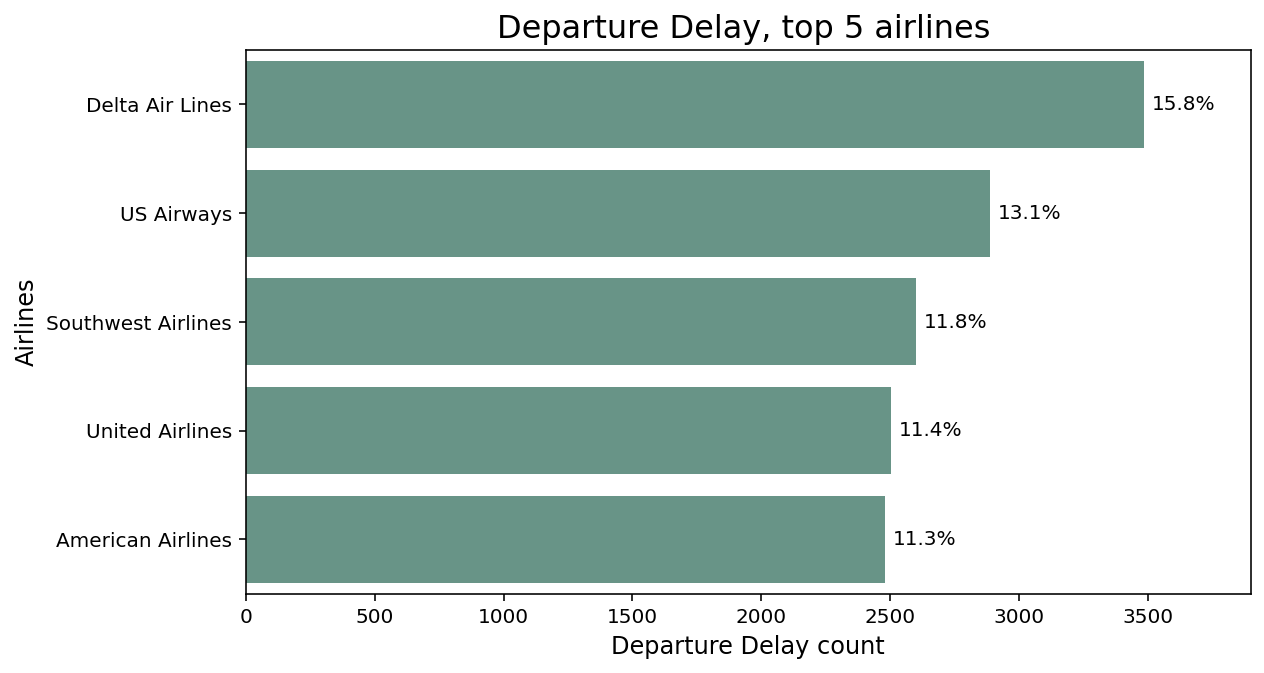

In [42]:
# Plot proportions of delays by top 5 airlines
delay_counts = flights.UniqueCarrier.value_counts()[:5]
carriers_order = delay_counts.index
plt.figure(figsize = [9, 5])

g = sb.countplot(data=flights, y='UniqueCarrier', color=color, order=carriers_order);
g.set_yticklabels(map_carrier_codes(carriers_order))

for i in range (delay_counts.shape[0]):
    count = delay_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/22000)
    plt.text(count+30, i, pct_string, va='center')
    plt.xlim((0,3900))
    
plt.xlabel('Departure Delay count', fontsize=12)
plt.ylabel('Airlines', fontsize=12)
plt.title('Departure Delay, top 5 airlines ', fontsize=16);

## Departure Delay over the years, top 5 busiest airlines
On the timeline plot, one of the top busiest aircompanies, Southwest Airlines has interesting change of mean delay: first 10 years of observation it was higher that others then in 2005 we see constant decrease. Other 4 carriers show slow increase in their departure delay means with a sharp increase at 2003, probably because the new report system was implemented and data became more accurate.

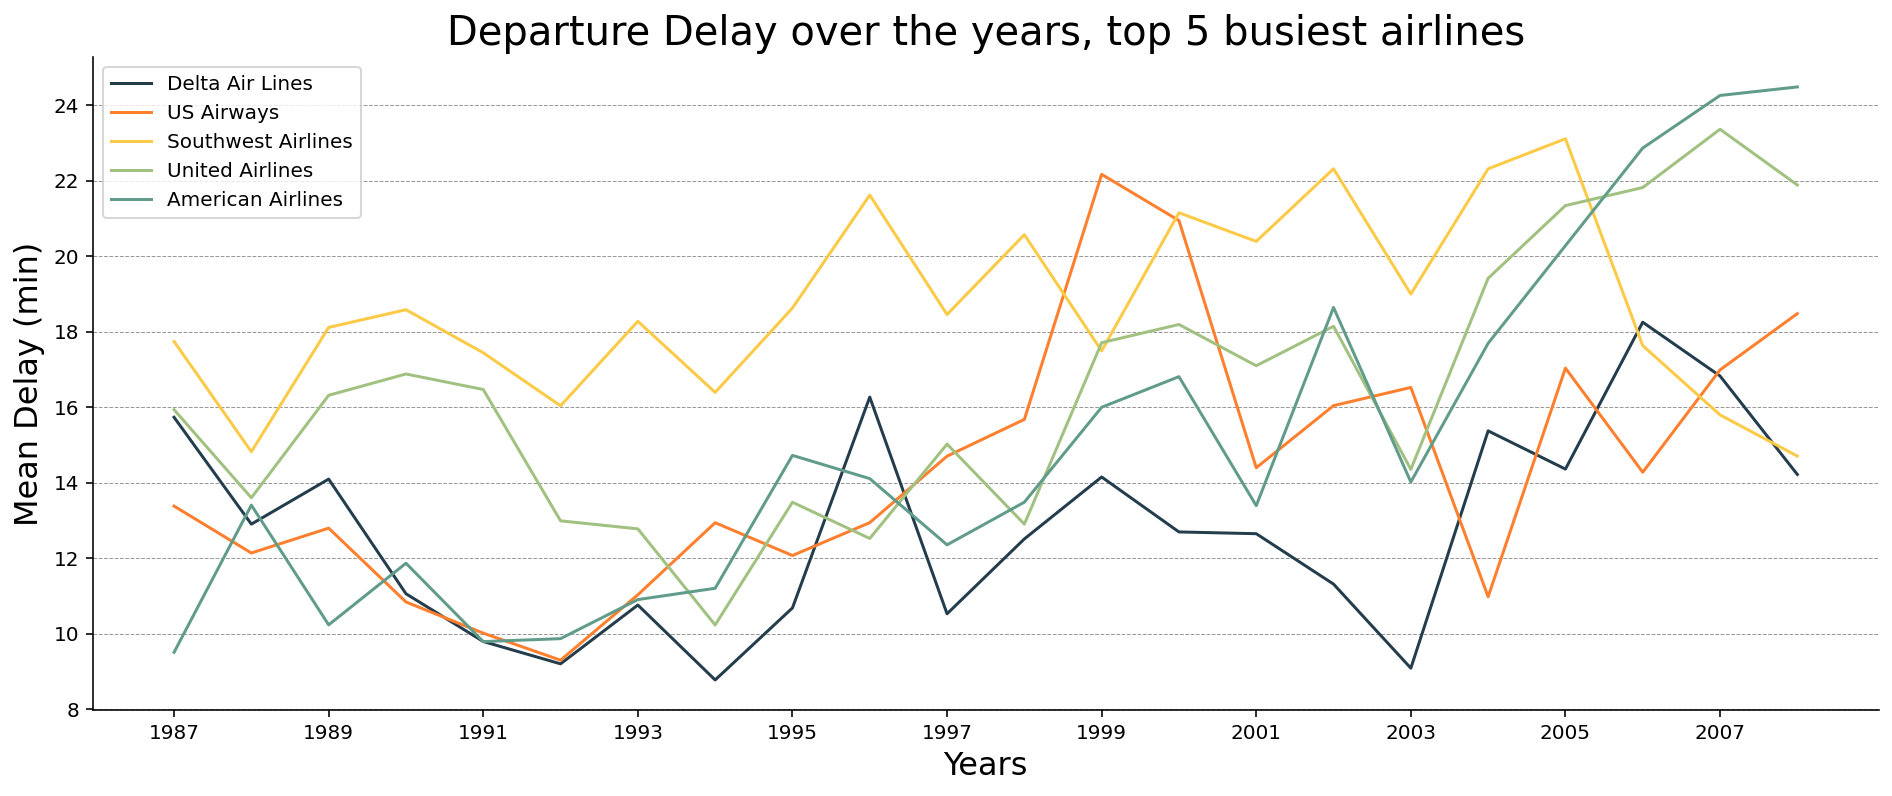

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

delay_handles = list(map(plot_delay, top5_airlines))
delay_labels = list(map(lambda params: airline_names[params['airline']], top5_airlines))

plt.legend(delay_handles, delay_labels)
plt.grid(axis='y', color='#999999', linestyle = '--', linewidth = 0.5)
sb.despine(top=True)
ax.set_ylabel('Mean Delay (min)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
plt.xticks(np.arange(1987, 2009, 2))
ax.set_title("Departure Delay over the years, top 5 busiest airlines" , fontsize=20);

## Average delay duration by delay cause

As to reported reasons for delays, 'CarrierDelay' and 'LateAircraftDelay' have stronger correlation with departure delays. Weather shows to have not so huge impact on delay average, LateAircraftDelay tends to be longer at the beginning of the year and CarrierDelay shows that avialines perform evenly with small decrease in November.

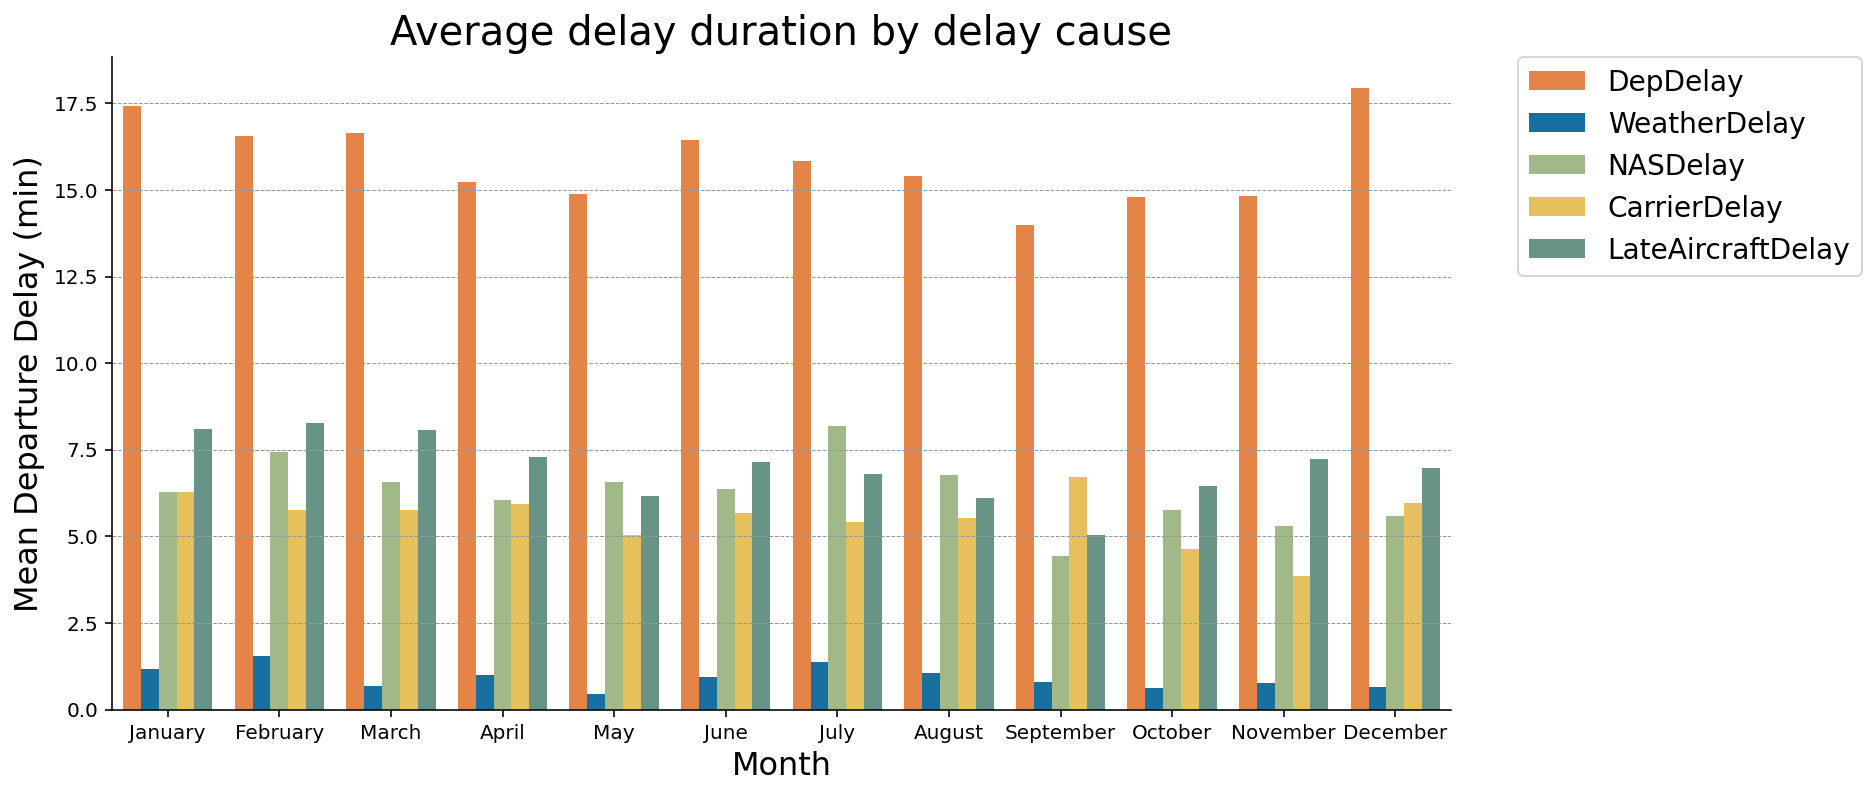

In [14]:
plt.figure(figsize = [12, 6])
ax = sb.barplot(data = month_tidy, x = 'Month', y = 'value', hue = 'variable', palette=del_colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
ax.set_xticklabels(months)
ax.set_ylabel('Mean Departure Delay (min)', fontsize=16)
ax.set_title('Average delay duration by delay cause', fontsize=20)
ax.set_xlabel('Month', fontsize=16)
plt.grid(axis='y', color='#999999', linestyle = '--', linewidth = 0.5)
sb.despine();

Departure Delay is widely distributed but most of the delays are within 1 hour. The mean is slowly increasing over the years. The similar trend is also observed among top 4 busiest airlines and 1 is surprisingly decreasing its delay times. Additionaly, departure delay has stronger correlation with 'WeatherDelay' and 'LateAircraftDelay' among all given reasons for delay.

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [11]:
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt

/bin/bash: Part_II_Filename: No such file or directory


> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 